# The Basic Network

The simplest neural net takes input vectors and performs classification or regression on those input vectors
* input: feature vector (batch_size, feature_size)
* output: real number vector (batch_size, n_out) or binary vector (batch_size,n_out)

In Keras, it is assumed that the first dimension is the batch size; meaning that each row represents a sample, and each column represents a feature
* row -> sample
* col -> feature

In [1]:
import pandas
import h5py
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import layer_utils
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from cat_data_utils import *


## Exploring and Massaging the data
We'll be borrowing the cat/non-cat dataset from Coursera Deep Learning Specialization for this exercise.

Load the dataset. It's already split into training and testing sets. Note that Keras has a built-in option to split data into training and dev sets as well.

The general procedure at this stage is to:
* Explore the dataset
* Get data into appropriate shapes
* Standardize data

In [2]:
# You should always explore your dataset. What are the feature dimensions? How many examples do you have?
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


We have a very small number of training and testing examples. Hopefully our network don't overfit!

y = 0. It's a non-cat picture.


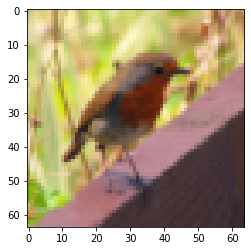

In [3]:
#Let's see what our images look like

index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

We reshape and standardize the images before feeding them into the network

In [4]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## Building a simple network
The general procedure will be
* Define model
* Compile model
* Train with `model.fit()`
* Test with `model.evaluate()`
* Predict on new data using `model.predict()`

### Sequential Model
We'll build the model in Keras. We'll define a sequential model (https://keras.io/guides/sequential_model/), and add the layers we want using `.add()`.

Later, we'll build more complicated models (like a residual network) that are not necessarily sequential. In that case, we'll define input layer explicitly and pass layers to eachother appropriately.

### Terminology
We'll use this simple network as an example
<img src="figures/basic_network.jpg" style="width:650px;">

#### Units
This network has 2 hidden layers, each with 4 *units*.
The output layer has 1 unit.

#### Input Shapes
The input tensor must have the same shape as your training data. e.g., if you are inputting images of (50x50x3), then your input layer tensor must have this shape.

Each type of layer requires the input with a certain number of dimensions
* `dense` layer requires `(batch_size, input_size)`
* 2D conv layers need `(batch_size, imageside1, imageside2, channels)` or `(batch_size, channels, imageside1, imageside2)`, depending on whether you're using `channels_last` or `channels_first`
* 1D conv and recurrent layers use `(batch_size, sequence_length, features)`
    * Details on how to prepare data for recurrent layers (https://stackoverflow.com/a/50235563/2097240)
    
#### Output Shapes
The type of layer and its properties define the output shape. Dense layers have output shape of `(batch_size,units)`

#### Keras ignore batch_size
Since batch_size is a variable, the first dimension doesn't need to be specified. In model summary, you'll see `none` as the first dimension. The exception is when you do operations on these densors directly, like in a lambda layer.

### A 4-layer network
We'll build a simple 4 layer network.
Its architecture will be:
* Input - where inputs are vectors of (12288,1)
* 3 fully connected, relu activation
* 1 fully connected, sigmoid activation
* Output - a single value representing the probability of whether or not the picture is a cat

In [5]:
# define base model and compile
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=12288, kernel_initializer='normal', activation='relu'))
    model.add(Dense(7, kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', metrics=["accuracy"], optimizer='adam')
    return model

In [6]:
model = baseline_model()

### Visualize model

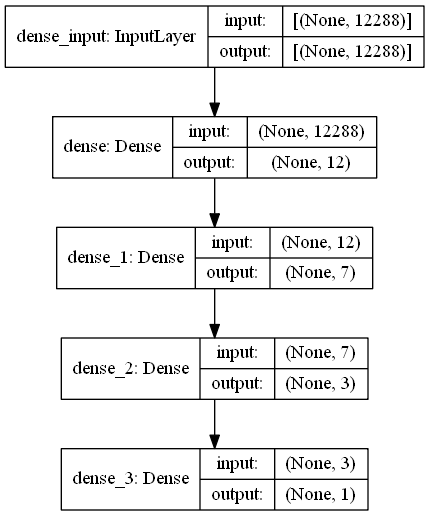

In [7]:
plot_model(model, to_file='HappyModel.png',show_shapes=True, show_layer_names=True)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                147468    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 91        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 24        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 147,587
Trainable params: 147,587
Non-trainable params: 0
_________________________________________________________________


### Train with model.fit

In [9]:
training_history = model.fit(x = train_x.T, y = train_y.T, validation_split = 0.05, epochs = 500, batch_size = 32, verbose=1)

Epoch 1/500
7/7 [==============================] - 1s 82ms/step - loss: 0.6911 - accuracy: 0.6618 - val_loss: 0.6653 - val_accuracy: 0.9091
Epoch 2/500
7/7 [==============================] - 0s 8ms/step - loss: 0.6806 - accuracy: 0.6475 - val_loss: 0.6247 - val_accuracy: 0.9091
Epoch 3/500
7/7 [==============================] - 0s 8ms/step - loss: 0.6637 - accuracy: 0.6593 - val_loss: 0.5679 - val_accuracy: 0.9091
Epoch 4/500
7/7 [==============================] - 0s 8ms/step - loss: 0.6654 - accuracy: 0.6318 - val_loss: 0.5291 - val_accuracy: 0.9091
Epoch 5/500
7/7 [==============================] - 0s 8ms/step - loss: 0.6494 - accuracy: 0.6553 - val_loss: 0.5019 - val_accuracy: 0.9091
Epoch 6/500
7/7 [==============================] - 0s 7ms/step - loss: 0.6701 - accuracy: 0.6277 - val_loss: 0.5184 - val_accuracy: 0.9091
Epoch 7/500
7/7 [==============================] - 0s 8ms/step - loss: 0.6656 - accuracy: 0.6283 - val_loss: 0.5340 - val_accuracy: 0.9091
Epoch 8/500
7/7 [=========

7/7 [==============================] - 0s 8ms/step - loss: 0.2178 - accuracy: 0.9495 - val_loss: 0.9980 - val_accuracy: 0.8182
Epoch 118/500
7/7 [==============================] - 0s 8ms/step - loss: 0.2250 - accuracy: 0.9560 - val_loss: 0.9846 - val_accuracy: 0.8182
Epoch 119/500
7/7 [==============================] - 0s 8ms/step - loss: 0.2389 - accuracy: 0.9375 - val_loss: 1.0141 - val_accuracy: 0.8182
Epoch 120/500
7/7 [==============================] - 0s 8ms/step - loss: 0.2492 - accuracy: 0.9408 - val_loss: 0.9871 - val_accuracy: 0.8182
Epoch 121/500
7/7 [==============================] - 0s 8ms/step - loss: 0.2274 - accuracy: 0.9540 - val_loss: 0.9608 - val_accuracy: 0.8182
Epoch 122/500
7/7 [==============================] - 0s 8ms/step - loss: 0.2182 - accuracy: 0.9368 - val_loss: 0.9458 - val_accuracy: 0.8182
Epoch 123/500
7/7 [==============================] - 0s 8ms/step - loss: 0.2307 - accuracy: 0.9505 - val_loss: 0.9900 - val_accuracy: 0.9091
Epoch 124/500
7/7 [========

7/7 [==============================] - 0s 8ms/step - loss: 0.1760 - accuracy: 0.9480 - val_loss: 1.0312 - val_accuracy: 0.4545
Epoch 234/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1950 - accuracy: 0.9369 - val_loss: 1.0586 - val_accuracy: 0.6364
Epoch 235/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1636 - accuracy: 0.9580 - val_loss: 1.1272 - val_accuracy: 0.8182
Epoch 236/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1879 - accuracy: 0.9387 - val_loss: 1.0330 - val_accuracy: 0.4545
Epoch 237/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1865 - accuracy: 0.9454 - val_loss: 1.1291 - val_accuracy: 0.8182
Epoch 238/500
7/7 [==============================] - 0s 9ms/step - loss: 0.1951 - accuracy: 0.9436 - val_loss: 1.1646 - val_accuracy: 0.8182
Epoch 239/500
7/7 [==============================] - 0s 20ms/step - loss: 0.1901 - accuracy: 0.9455 - val_loss: 1.1126 - val_accuracy: 0.6364
Epoch 240/500
7/7 [=======

7/7 [==============================] - 0s 9ms/step - loss: 0.1709 - accuracy: 0.9422 - val_loss: 1.3125 - val_accuracy: 0.5455
Epoch 350/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1670 - accuracy: 0.9468 - val_loss: 1.2877 - val_accuracy: 0.5455
Epoch 351/500
7/7 [==============================] - 0s 9ms/step - loss: 0.1868 - accuracy: 0.9365 - val_loss: 1.3524 - val_accuracy: 0.8182
Epoch 352/500
7/7 [==============================] - 0s 9ms/step - loss: 0.1591 - accuracy: 0.9495 - val_loss: 1.2199 - val_accuracy: 0.4545
Epoch 353/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1579 - accuracy: 0.9563 - val_loss: 1.4091 - val_accuracy: 0.8182
Epoch 354/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1562 - accuracy: 0.9534 - val_loss: 1.4666 - val_accuracy: 0.5455
Epoch 355/500
7/7 [==============================] - 0s 8ms/step - loss: 0.2094 - accuracy: 0.9175 - val_loss: 1.5167 - val_accuracy: 0.2727
Epoch 356/500
7/7 [========

7/7 [==============================] - 0s 8ms/step - loss: 0.1049 - accuracy: 0.9736 - val_loss: 2.0051 - val_accuracy: 0.9091
Epoch 466/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1390 - accuracy: 0.9564 - val_loss: 1.9589 - val_accuracy: 0.7273
Epoch 467/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1171 - accuracy: 0.9723 - val_loss: 2.0103 - val_accuracy: 0.6364
Epoch 468/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1326 - accuracy: 0.9569 - val_loss: 1.9729 - val_accuracy: 0.7273
Epoch 469/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1169 - accuracy: 0.9710 - val_loss: 2.0691 - val_accuracy: 0.9091
Epoch 470/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1159 - accuracy: 0.9761 - val_loss: 2.0363 - val_accuracy: 0.8182
Epoch 471/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1122 - accuracy: 0.9702 - val_loss: 2.0645 - val_accuracy: 0.8182
Epoch 472/500
7/7 [========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


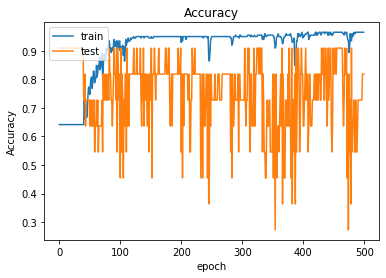

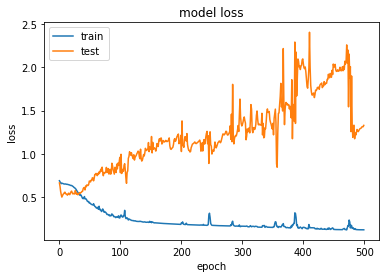

In [10]:
print(training_history.history.keys())
# summarize history for accuracy
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [11]:
_, accuracy = model.evaluate(x = train_x.T, y = train_y.T)

7/7 [==============================] - 0s 1ms/step - loss: 0.1879 - accuracy: 0.9569


In [12]:
_, accuracy = model.evaluate(x = test_x.T, y = test_y.T)

2/2 [==============================] - 0s 2ms/step - loss: 2.7943 - accuracy: 0.7400


From our accurate and loss plots, we see that **we're overfitting our data**. So we should consider expanding our model, or collect more data.


## Predict
Now that our model is working, let's use it to predict whether an image is a cat.

If `.predict()` return a number close to 0, then it's not a cat.

In [1]:
# it's important to use np.expand_dims() here to get the shape of our vectors to be (1,features) rather than (,features)
sample_idx = 20
x_pred = train_x[:,sample_idx]
x_pred = np.expand_dims(x_pred, axis=0)
x_pred.shape

NameError: name 'train_x' is not defined

In [14]:
print(model.predict(x_pred))

[[2.588264e-14]]
